Importing a few things

In [1]:
# OpenMDAO imports
from openmdao.main.datatypes.array import Array
from openmdao.main.datatypes.float import Float
from openmdao.main.datatypes.list import List
from openmdao.main.component import Component


# FUSED-Wind imports
from fusedwind.plant_flow.asym import AEPMultipleWindRoses, AEPSingleWindRose, BaseAEPModel
from fusedwind.interface import InterfaceSlot, implement_base
from fusedwind.plant_flow.comp import GenericWindFarm

# GCLarsen import
#from gclarsen.fused import FGCLarsen

from topfarm.tlib import TopfarmComponent

# Other
import numpy as np
from scipy.interpolate import interp1d



:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:

# OpenMDAO imports
#from openmdao.main.api import Assembly
#from openmdao.lib.datatypes.api import VarTree, Float, Slot, Array, List, Int, Str, Dict, Enum

# FUSEDWind imports
#from fusedwind.interface import implement_base, InterfaceSlot
#from fusedwind.plant_flow.comp import GenericWindFarm
from fusedwind.plant_flow.vt import GenericWindFarmTurbineLayout, WTPC, WeibullWindRoseVT, GenericWindRoseVT


# Topfarm lib imports
from topfarm.aep import AEP
from topfarm.layout_distribution import spiral, DistributeSpiral, DistributeXY, DistributeFilledPolygon
from topfarm.plot import OffshorePlot, PrintOutputs
from topfarm.tlib import ConverHullArea, DistFromTurbines, PolyFill, document, DistFromBorders
from topfarm.foundation import FoundationLength
from topfarm.elnet import ElNetLength, elnet
from topfarm.optimizers import *
from topfarm.topfarm import Topfarm

#GCL imports
from gclarsen.fusedwasp import PlantFromWWH, WTDescFromWTG
from gclarsen.fused import FGCLarsen

from numpy import *
import numpy as np

# For plotting
import pylab as plt

### Loading all the input data

In [3]:
datadir = '/Users/pire/git/FUSED-TOPFARM/src/topfarm/test/data/'
dat = loadtxt(datadir+'WaterDepth1.dat')
X, Y = meshgrid(linspace(0., 1000., 50), linspace(0., 1000., 50))
depth = array(zip(X.flatten(), Y.flatten(), dat.flatten()))
borders = array([[200, 200], [150, 500], [200, 800], [600, 900], [700, 700], [900, 500], [800, 200], [500, 100], [200, 200]])
baseline = array([[587.5, 223.07692308], [525., 346.15384615], [837.5, 530.76923077], [525., 530.76923077], [525., 838.46153846], [837.5, 469.23076923]])

wt_desc = WTDescFromWTG(datadir+'V80-2MW-offshore.wtg').wt_desc
wt_layout = GenericWindFarmTurbineLayout([WTPC(wt_desc=wt_desc, position=pos) for pos in baseline])


# The wind rose
weibull_array = np.array([[  0.00000000e+00,   3.59673400e-02,  9.22422800e+00,   2.38867200e+00],
                         [  3.00000000e+01,   3.94977300e-02,   9.86435600e+00,   2.44726600e+00],
                         [  6.00000000e+01,   5.17838000e-02,   9.65220200e+00,   2.41992200e+00],
                         [  9.00000000e+01,   6.99794900e-02,   9.98217800e+00,   2.58789100e+00],
                         [  1.20000000e+02,   8.36383000e-02,   1.00946000e+01,   2.74804700e+00],
                         [  1.50000000e+02,   6.43412500e-02,   9.64369000e+00,   2.59179700e+00],
                         [  1.80000000e+02,   8.64220000e-02,   9.63377500e+00,   2.58007800e+00],
                         [  2.10000000e+02,   1.17690000e-01,   1.05678600e+01,   2.54492200e+00],
                         [  2.40000000e+02,   1.51555100e-01,   1.14525200e+01,   2.46679700e+00],
                         [  2.70000000e+02,   1.47361100e-01,   1.17423700e+01,   2.60351600e+00],
                         [  3.00000000e+02,   1.00109800e-01,   1.16923200e+01,   2.62304700e+00],
                         [  3.30000000e+02,   5.16542400e-02,   1.01385800e+01,   2.32226600e+00]])
wind_rose = WeibullWindRoseVT()
wind_rose.wind_directions = weibull_array[:,0]
wind_rose.frequency = weibull_array[:,1]
wind_rose.k = weibull_array[:,3]
wind_rose.A = weibull_array[:,2]

# Minimum distance between turbines
dist_WT_D = 3.0


#### Plotting the depth

Some matplotlib options

In [4]:
%matplotlib inline
import pylab as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
# To see all the options:
#plt.rcParams.keys()

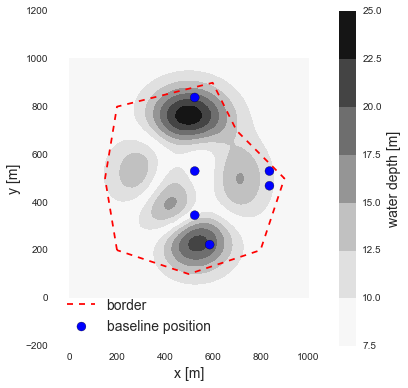

In [7]:

N = 100
X, Y = plt.meshgrid(plt.linspace(depth[:,0].min(), depth[:,0].max(), N), 
                    plt.linspace(depth[:,1].min(), depth[:,1].max(), N))
Z = plt.griddata(depth[:,0],depth[:,1],depth[:,2],X,Y, interp='linear')

fig = plt.figure(figsize=(6,6), dpi=2000)
fs = 14
ax = plt.subplot(111)
plt.contourf(X,Y,Z, label='depth [m]')
#ax.plot(wt_layout.wt_positions[:,0], wt_layout.wt_positions[:,1], 'or', label='baseline position')
ax.scatter(wt_layout.wt_positions[:,0], wt_layout.wt_positions[:,1], wt_layout._wt_list('rotor_diameter'), label='baseline position')
ax.plot(borders[:,0], borders[:,1], 'r--', label='border')
ax.set_xlabel('x [m]'); 
ax.set_ylabel('y [m]')
ax.axis('equal');
ax.legend(loc='lower left')
plt.colorbar().set_label('water depth [m]')


The red points indicate the position of the baseline turbines, the contour plot illustrate the water depth in meters and the red line illustrates the position of the borders limiting the domain of exploration of the optimization.

#### Plot the wind rose

In [26]:
class A(object):
    def run(self,a):
        return a/0.0
        
a = A()

a.run(1)

ZeroDivisionError: float division by zero

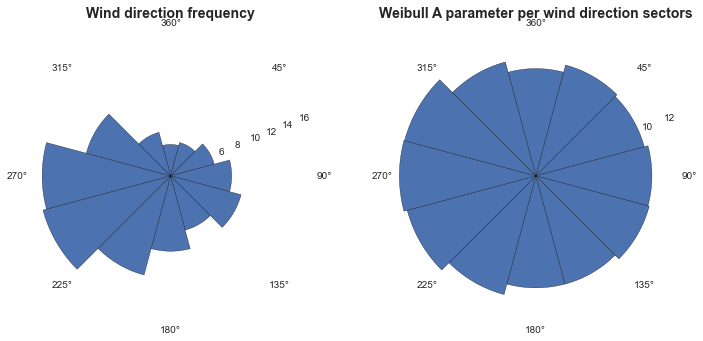

In [8]:
fig = plt.figure(figsize=(12,5), dpi=1000)

# Plotting the wind statistics
ax1 = plt.subplot(121, polar=True)
w = 2.*np.pi/len(wind_rose.frequency)
b = ax1.bar(pi/2.0-np.array(wind_rose.wind_directions)/180.*np.pi - w/2.0, 
            np.array(wind_rose.frequency)*100, width=w)

# Trick to set the right axes (by default it's not oriented as we are used to in the WE community)
mirror = lambda d: 90.0 - d if d < 90.0 else 360.0 + (90.0 - d)
ax1.set_xticklabels([u'%d\xb0'%(mirror(d)) for d in linspace(0.0, 360.0,9)[:-1]]);
ax1.set_title('Wind direction frequency');

# Plotting the Weibull A parameter
ax2 = plt.subplot(122, polar=True)
b = ax2.bar(pi/2.0-np.array(wind_rose.wind_directions)/180.*np.pi - w/2.0, 
            np.array(wind_rose.A), width=w)
ax2.set_xticklabels([u'%d\xb0'%(mirror(d)) for d in linspace(0.0, 360.0,9)[:-1]]);
ax2.set_title('Weibull A parameter per wind direction sectors');

### Setting up TOPFARM

#### Calculating the wind farm AEP

In [9]:
ws = linspace(4, 25, 21)
wd = linspace(0, 360, 37)[:-1]

In [11]:
aep = AEP(wt_layout=wt_layout, 
          wind_rose=wind_rose, 
          wf=FGCLarsen(),
          wind_speeds=ws,
          wind_directions=wd,
          scaling=1.0,
          wt_positions=baseline)
aep.run()
print 'Net AEP=',aep.net_aep/1e6, 'MWh'

1.0
Net AEP= 50579.2094652 MWh


Getting the inputs and outputs of the OpenMDAO components

In [15]:
document(CONMINdriver)

INPUTS:
-------
force_fd = False 
	If True, always finite difference this component.
dabfun = 0.001 
	Absolute convergence tolerance.
ctl = -0.01 
	Constraint thickness parameter for linear and side constraints.
iprint = 0 
	Print information during CONMIN solution. Higher values are more verbose. 0 suppresses all output.
fdchm = 0.01 
	Minimum absolute step in finite difference gradient calculations (only when CONMIN calculates gradient).
phi = 5.0 
	Participation coefficient - penalty parameter that pushes designs towards the feasible region.
fdch = 0.01 
	Relative change in parameters when calculating finite difference gradients (only when CONMIN calculates gradient).
icndir = 0.0 
	Conjugate gradient restart. parameter.
itrm = 3 
	Number of consecutive iterations to indicate convergence (relative or absolute).
conmin_diff = False 
	Set to True to let CONMINcalculate the gradient.
linobj = False 
	Linear objective function flag. Set to True if objective is linear.
directory =  
	If 

Optimize only the foundation length

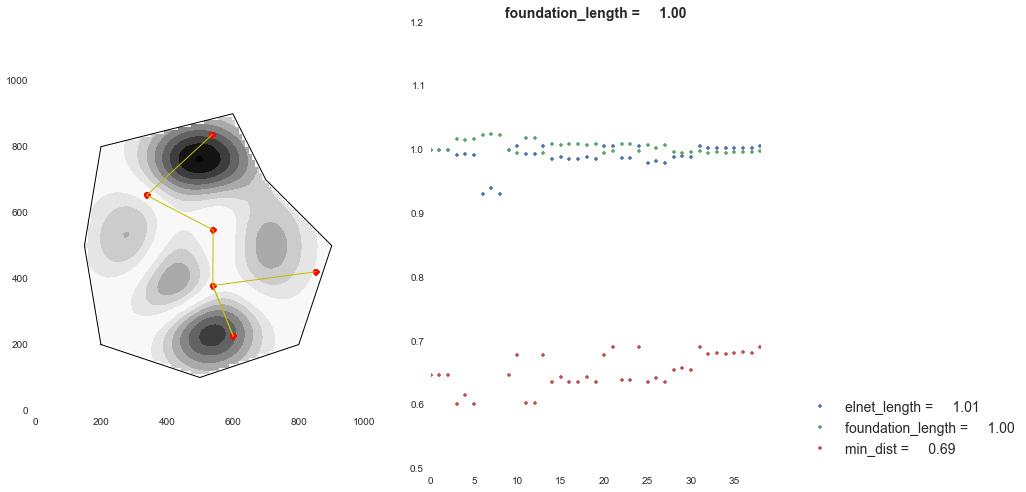

In [22]:

components = {
    'foundation': FoundationLength(borders=borders, scaling=0.0, depth=depth),
    'distribute': DistributeXY(wt_layout=wt_layout, borders=borders),
    'elnet': ElNetLength(scaling=0.0),
    'wt_dist': DistFromTurbines(scaling=wt_desc.rotor_diameter * dist_WT_D),
    'dist_from_borders': DistFromBorders(wt_layout=wt_layout, borders=borders, scaling=0.0),
    'plotting': OffshorePlot(baseline=baseline, borders=borders, depth=depth, distribution='xy', 
                             add_inputs=['elnet_length', 'foundation_length', 'min_dist' ],
                             title='foundation_length'),
    'driver': CONMINOpt()}
#COBYLAOpt(rhobeg=1e-2)}

workflows =   {'driver': ['distribute', 'foundation','wt_dist', 'elnet', 'dist_from_borders', 'plotting']}

#objectives =  {'driver': 'foundation.foundation_length'}
objectives =  {'driver': '0.5 * foundation.foundation_length + 0.5*elnet.elnet_length'}

constraints = {'driver': ['wt_dist.min_dist>0.8', 
                          'elnet.elnet_length<1.1', 
                          'dist_from_borders'
                          ]}

design_variables = {'driver': 'distribute'}

connections = {'distribute.wt_positions': ['foundation.wt_positions',
                                            'wt_dist.wt_positions',
                                            'plotting.wt_positions',
                                           'elnet.wt_positions',
                                          'dist_from_borders.wt_positions'],
               'foundation.foundation_length': 'plotting.foundation_length',
               'foundation.foundations': 'plotting.foundations',
               'elnet.elnet_layout': 'plotting.elnet_layout',
               'elnet.elnet_length': 'plotting.elnet_length',               
               'wt_dist.min_dist': 'plotting.min_dist'}

input_parameters = {}

top = Topfarm(components, workflows, objectives, constraints, design_variables, connections, input_parameters)
top.run()

#### Optimization using the AEP

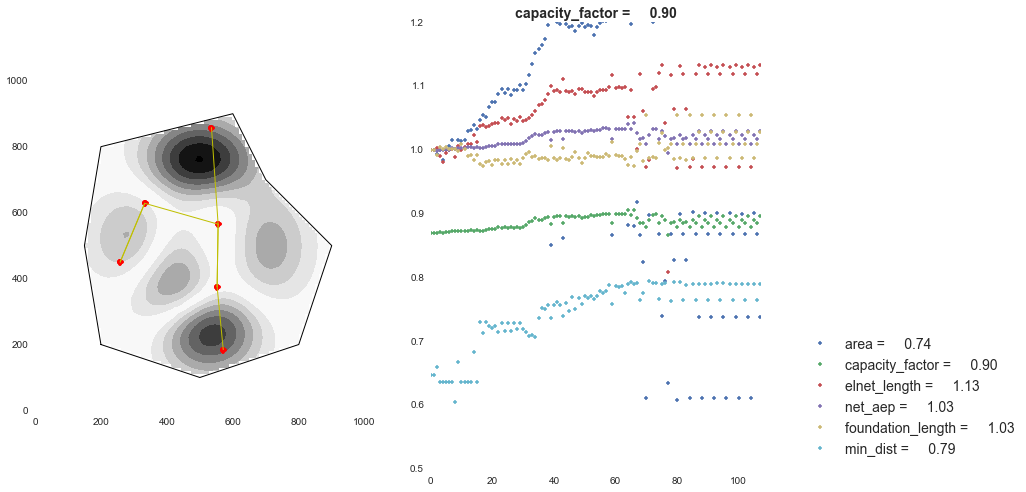

In [24]:
components = {
    'elnet': ElNetLength(scaling=0.0),
    'foundation': FoundationLength(borders=borders, scaling=0.0, depth=depth),
    'aep': AEP(wt_layout=wt_layout, 
               wind_rose=wind_rose, 
               wf=FGCLarsen(),
               wind_speeds=[4, 8, 12],
               wind_directions=linspace(0, 360, 12)[:-1],
               scaling=0.0),
    'area': ConverHullArea(wt_layout=wt_layout, scaling=0.0),
    'dist_from_borders': DistFromBorders(wt_layout=wt_layout, borders=borders, scaling=0.0),    
    'wt_dist': DistFromTurbines(scaling=wt_desc.rotor_diameter * dist_WT_D),
    'distribute': DistributeFilledPolygon(wt_layout=wt_layout, borders=borders),
    'plotting': OffshorePlot(baseline=baseline, borders=borders, depth=depth, distribution='xy',
                             add_inputs=['area', 'capacity_factor', 'elnet_length', 'net_aep', 'foundation_length', 'min_dist' ],
                             title='capacity_factor'),
    'driver': COBYLAOpt(rhobeg=1e-2)}
workflows =   {'driver': ['distribute', 'foundation', 'elnet', 'aep', 'area', 'dist_from_borders', 'wt_dist', 'plotting']}

objectives =  {'driver': '-aep.net_aep'}
# objectives =  {'driver': '-aep.net_aep + 0.4*elnet.elnet_length'}
#objectives =  {'driver': '-aep.capacity_factor/area.area'}

constraints = {'driver': ['wt_dist.min_dist>0.8',
                          'foundation.foundation_length<1.02'
                         # 'dist_from_borders'
                         #'foundation.foundation_length<1.02',
                         #'elnet.elnet_length<1.02',
                          ]}

design_variables = {'driver': 'distribute'}

connections = {'distribute.wt_positions': ['foundation.wt_positions',
                                            'elnet.wt_positions',
                                            'wt_dist.wt_positions',
                                            'aep.wt_positions',
                                            'plotting.wt_positions',
                                           'dist_from_borders.wt_positions',
                                           'area.wt_positions'],
               'foundation.foundation_length': 'plotting.foundation_length',
               'foundation.foundations': 'plotting.foundations',
               'elnet.elnet_layout': 'plotting.elnet_layout',
               'elnet.elnet_length': 'plotting.elnet_length',
               'wt_dist.min_dist': 'plotting.min_dist',
               'aep.capacity_factor': 'plotting.capacity_factor',
               'aep.net_aep': 'plotting.net_aep',
               'area.area': 'plotting.area'}

input_parameters = {}
top = Topfarm(components, workflows, objectives, constraints, design_variables, connections, input_parameters)
top.run()

In [ ]:
baseline = top.distribute.wt_positions

In [ ]:
from openmdao.main.api import Assembly, Component
from openmdao.lib.drivers.api import DOEdriver, COBYLAdriver
from openmdao.lib.doegenerators.api import Uniform

from openmdao.examples.simple.paraboloid import Paraboloid

from openmdao.lib.casehandlers.api import JSONCaseRecorder, ListCaseRecorder

class Optimization(Assembly):

    def configure(self):
        self.add('paraboloid', Paraboloid())

        self.add('driver', COBYLAdriver())
        
        self.driver.add_parameter('paraboloid.x', low=-50, high=50)
        self.driver.add_parameter('paraboloid.y', low=-50, high=50)

        self.driver.add_objective('paraboloid.f_xy')

        self.recorders = [ListCaseRecorder()]



In [ ]:
class Analysis(Assembly):
    def configure(self):
        self.add('paraboloid', Paraboloid())

        self.add('driver', DOEdriver())
        self.driver.DOEgenerator = Uniform(1000)

        self.driver.add_parameter('paraboloid.x', low=-50, high=50)
        self.driver.add_parameter('paraboloid.y', low=-50, high=50)

        self.driver.add_response('paraboloid.f_xy')

        self.recorders = [ListCaseRecorder()]

    

In [ ]:

#----------------------------------------------------
# Print out history of our objective for inspection
#----------------------------------------------------


In [ ]:
from topfarm.tlib import listcase2df

analysis = Optimization()
analysis.run()


df = listcase2df(analysis.recorders[0])

In [ ]:
%matplotlib inline
import pylab as plt
import numpy as np
from fusedwind.fused_helper import *

In [ ]:
def contour_plot(func):
    rose = func()
    XS, YS = plt.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2,2, 20));
    ZS = np.array([rose(x1=x, x2=y).f_xy for x,y in zip(XS.flatten(),YS.flatten())]).reshape(XS.shape);
    plt.contourf(XS, YS, ZS, 50);
    plt.colorbar()
contour_plot(Paraboloid())    

df.plot(x='paraboloid.x', y='paraboloid.y', ls='', marker='.')